# Importing Libraries

In [11]:
import ase.io # for reading *.xyz
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting error distribution
import numpy as np

# Setting Variables and Functions

In [12]:
DATASET_LOCATION = "../data_structures_errors.xyz" # should be in the same directory as the repository

In [13]:
def sort_plot_df(df, sort_method): # to sort df by certain column and display the scatter plot
    df_sorted = df.sort_values(by=[sort_method])

    plt.figure(figsize=(20,10))
    plt.xlabel(sort_method.capitalize())
    plt.ylabel("Energy (Error)")

    plt.ylim(-1.1*df["energy (error)"].abs().max(), 1.1*df["energy (error)"].abs().max())

    # plt.plot(df_sorted[sort_method], df_sorted['energy (error)']) # having lines crowds the entire graph
    plt.scatter(df_sorted[sort_method], df_sorted['energy (error)'], s=10)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.show()

# Reading and Importing Dataset

In [ ]:
dataset_list = list(ase.io.iread(filename=DATASET_LOCATION, format="extxyz")) # reading *.xyz file as a generator, then converting into list
df = pd.DataFrame(dataset_list)

In [14]:
df["number of atoms"] = [dataset_list[i].get_global_number_of_atoms() for i in range(len(dataset_list))]
df["chemical formula"] = [dataset_list[i].get_chemical_formula() for i in range(len(dataset_list))]
df["Lattice (unit cell with three vectors)"] = [dataset_list[i].get_cell()[:] for i in range(len(dataset_list))]

df["Lattice vector length 1"] = [dataset_list[i].cell.cellpar()[0] for i in range(len(dataset_list))]
df["Lattice vector length 2"] = [dataset_list[i].cell.cellpar()[1] for i in range(len(dataset_list))]
df["Lattice vector length 3"] = [dataset_list[i].cell.cellpar()[2] for i in range(len(dataset_list))]

df["volume of unit cell (derived from Lattice)"] = [dataset_list[i].get_cell().volume for i in range(len(dataset_list))]
df["energy (error)"] = [dataset_list[i].info["energy"] for i in range(len(dataset_list))]
# Properties part not impt; pbc is "T T T" for all

display(df.head())
print(df.shape)

c:\Users\Yeo Hong\AppData\Local\Programs\Python\Python311\Lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)
c:\Users\Yeo Hong\AppData\Local\Programs\Python\Python311\Lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)
c:\Users\Yeo Hong\AppData\Local\Programs\Python\Python311\Lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


,0,1,2,3,4,5,6,7,8,9,...,223,224,number of atoms,chemical formula,Lattice (unit cell with three vectors),Lattice vector length 1,Lattice vector length 2,Lattice vector length 3,volume of unit cell (derived from Lattice),energy (error)
0,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,None,None,86,HAl60NRh24,"[[11.832514762878418, 0.0, -0.0263979993760585...",11.832544,16.758482,31.385263,6104.848367,0.325074
1,"Atom('Zr', [5.31270552, 11.38425636, 12.790607...","Atom('Zr', [5.31270552, 4.67047501, 12.7906074...","Atom('Zr', [2.12508202, 4.67047501, 10.9502325...","Atom('Zr', [8.50032902, 11.38425636, 10.950232...","Atom('Zr', [7.43778753, 8.75708675, 12.7906074...","Atom('Zr', [1.06254113, 2.04330564, 12.7906074...","Atom('Zr', [4.25016451, 2.04330564, 10.9502315...","Atom('Zr', [4.25016451, 8.75708675, 10.9502315...","Atom('Zr', [5.31270552, 11.38425636, 16.471357...","Atom('Zr', [5.31270552, 4.67047501, 16.4713573...",...,None,None,85,C2HN32O2Se16Zr32,"[[12.750493049621582, 0.0, 0.0], [3.1876232624...",12.750493,13.922907,29.446003,5041.392243,-1.486445
2,"Atom('Ag', [1.99755764, 0.0, 12.556077], index=0)","Atom('Ag', [1.99755764, 0.0, 16.55119133], ind...","Atom('Ag', [1.99755764, 0.0, 20.54630661], ind...","Atom('Ag', [5.99267292, 0.0, 12.556077], index=3)","Atom('Ag', [5.99267292, 0.0, 16.55119133], ind...","Atom('Ag', [5.99267292, 0.0, 20.54630661], ind...","Atom('Ag', [9.9877882, 0.0, 12.556077], index=6)","Atom('Ag', [9.9877882, 0.0, 16.55119133], inde...","Atom('Ag', [9.9877882, 0.0, 20.54630661], inde...","Atom('P', [0.0, 3.52585888, 10.55851936], inde...",...,None,None,66,H2Ag9OP9Pd45,"[[11.985345840454102, 0.0, 0.0], [0.0, 7.05171...",11.985346,8.104793,35.956036,3038.906189,0.198341
3,"Atom('Hf', [9.38242626, 12.50322628, 14.585413...","Atom('Hf', [6.35710812, 3.12580657, 18.5775795...","Atom('Hf', [7.86976767, 7.81451654, 21.8971786...","Atom('Hf', [6.96020222, 13.28467846, 19.901096...","Atom('Hf', [3.93488359, 3.90725827, 23.8932628...","Atom('Hf', [5.44754267, 8.59596825, 16.5814971...","Atom('Hf', [6.20387268, 10.94032288, 18.241296...","Atom('Hf', [3.17855406, 1.56290329, 22.2334613...","Atom('Hf', [4.69121313, 6.25161314, 14.9216957...","Atom('Hf', [5.60077858, 0.7814517, 16.91777992...",...,None,None,62,C2H5Hf30OSn24,"[[8.023002624511719, 0.0, -3.6558828353881836]...",8.816692,14.795323,42.525463,4799.108881,-5.876447
4,"Atom('Tc', [5.52350187, 3.18899536, 15.7963838...","Atom('Tc', [8.28525257, 7.9724884, 20.15400696...","Atom('Tc', [2.76175094, 1.59449768, 17.9751968...","Atom('Tc', [5.52350187, 6.37799072, 17.9751968...","Atom('Tc', [5.52350187, 3.18899536, 20.1540069...","Atom('Tc', [8.28525257, 7.9724884, 24.51163101...","Atom('Tc', [2.76175094, 1.59449768, 22.3328189...","Atom('Tc', [5.52350187, 6.37799072, 22.3328189...","Atom('Tc', [11.04700375, 3.18899536, 15.796383...","Atom('Tc', [13.80875492, 7.9724884, 20.1540069...",...,None,None,67,CH2Os48Tc16,"[[11.047003746032715, 0.0, 0.0], [5.5235018730...",11.047004,11.875402,34.860985,3684.336555,-2.103216


(460333, 233)


# Distribution of Error when Sorted by Volume of Unit Cell

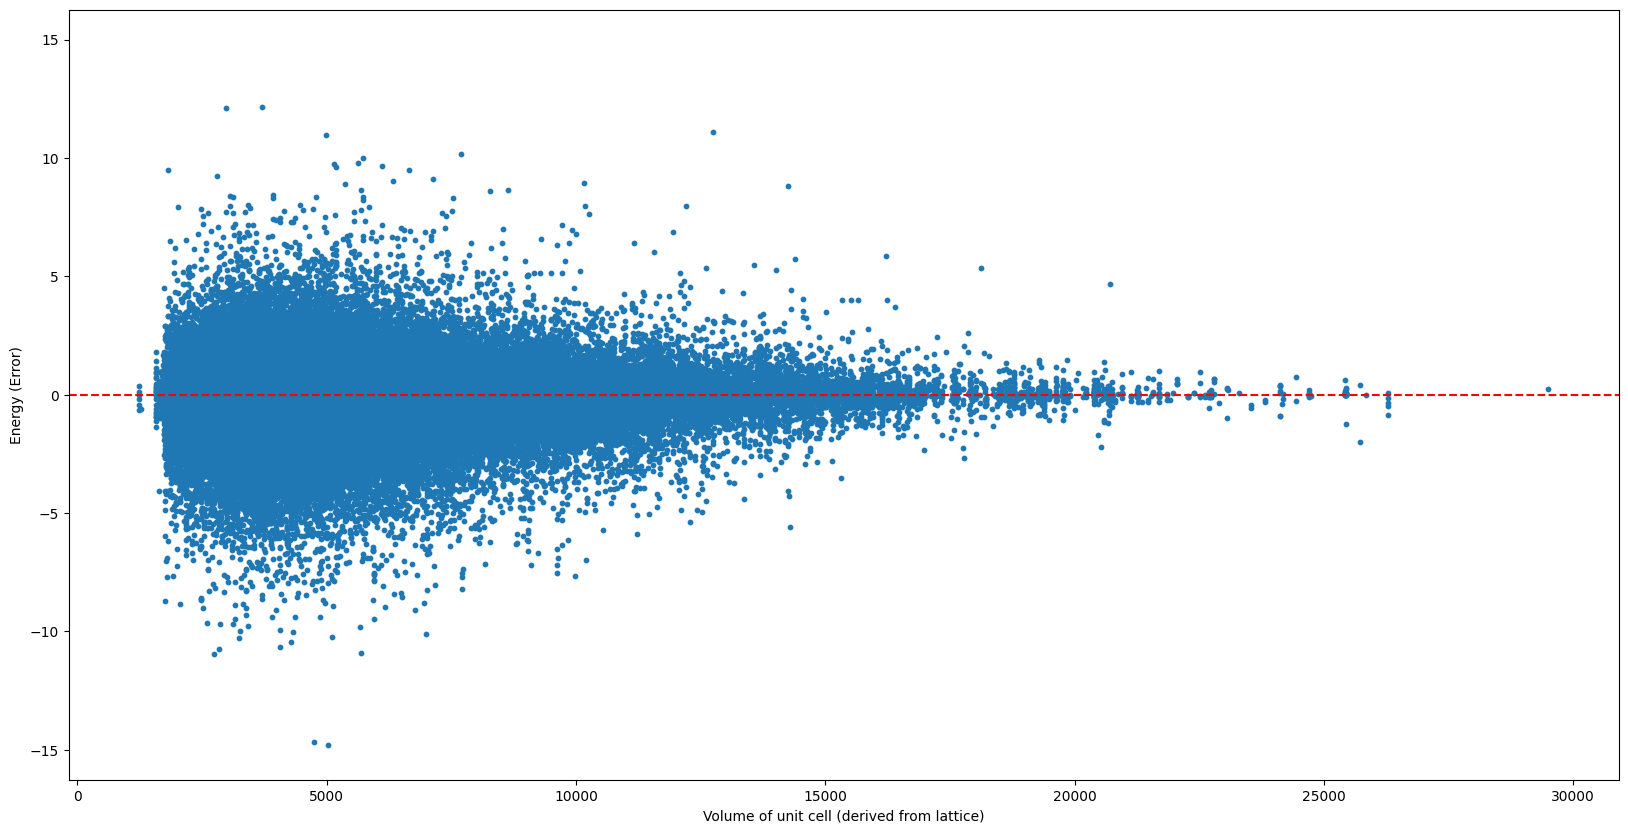

In [15]:
sort_plot_df(df, "volume of unit cell (derived from Lattice)")
# sort_plot_df(df, "number of atoms") # no trend

# possible way of extracting data out from Atom object
# print(df[0][0])
# print(df[0][0].symbol)
# print(df[0][0].position)
# display(df.describe())

# Distribution of Error when Sorted by Unit Cell Vectors

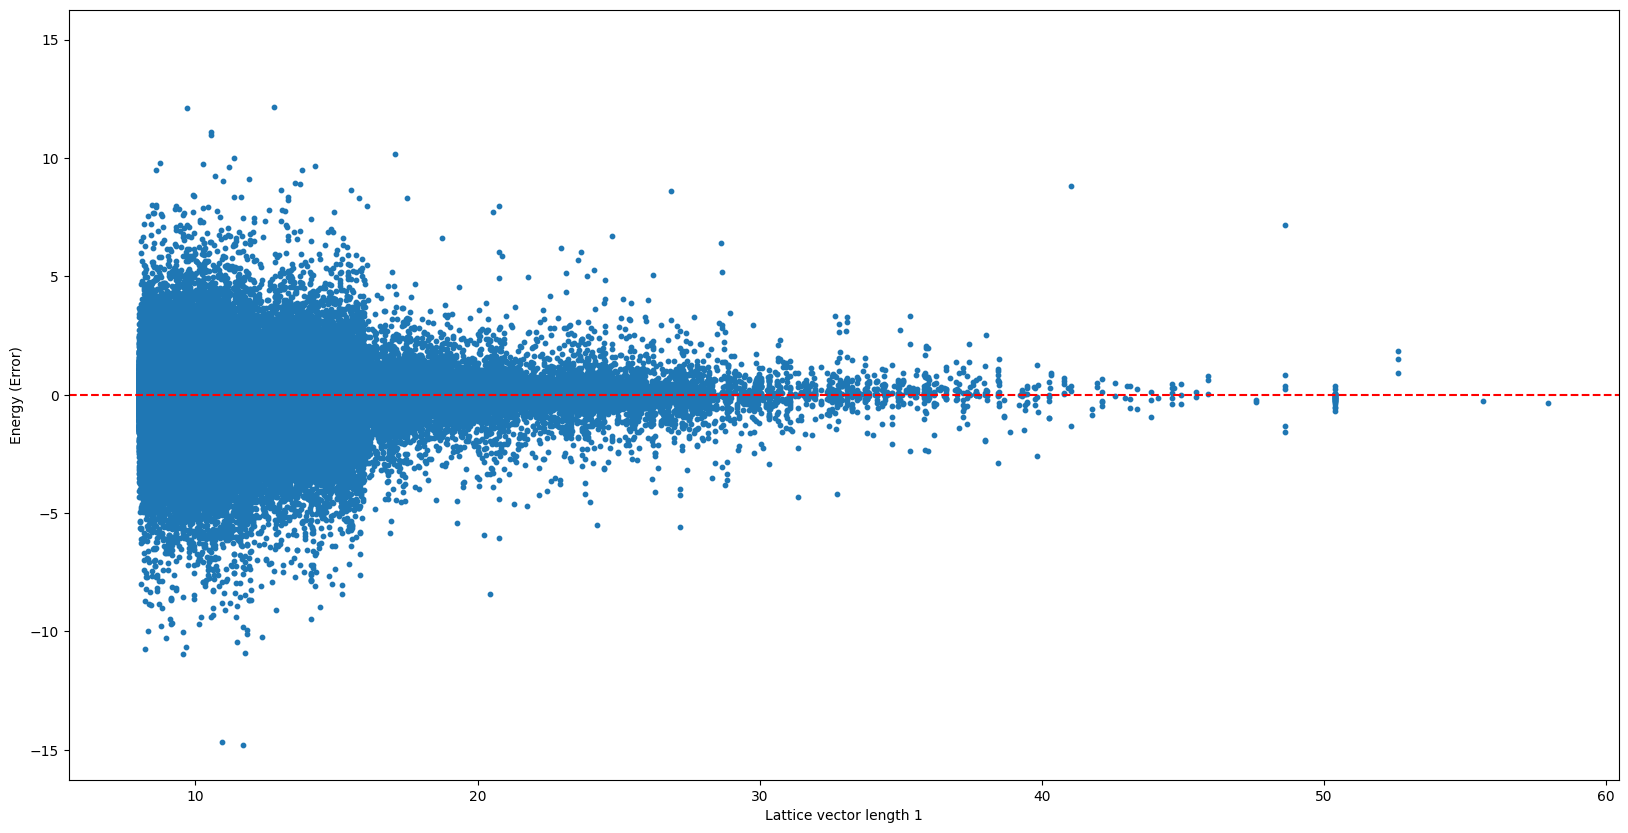

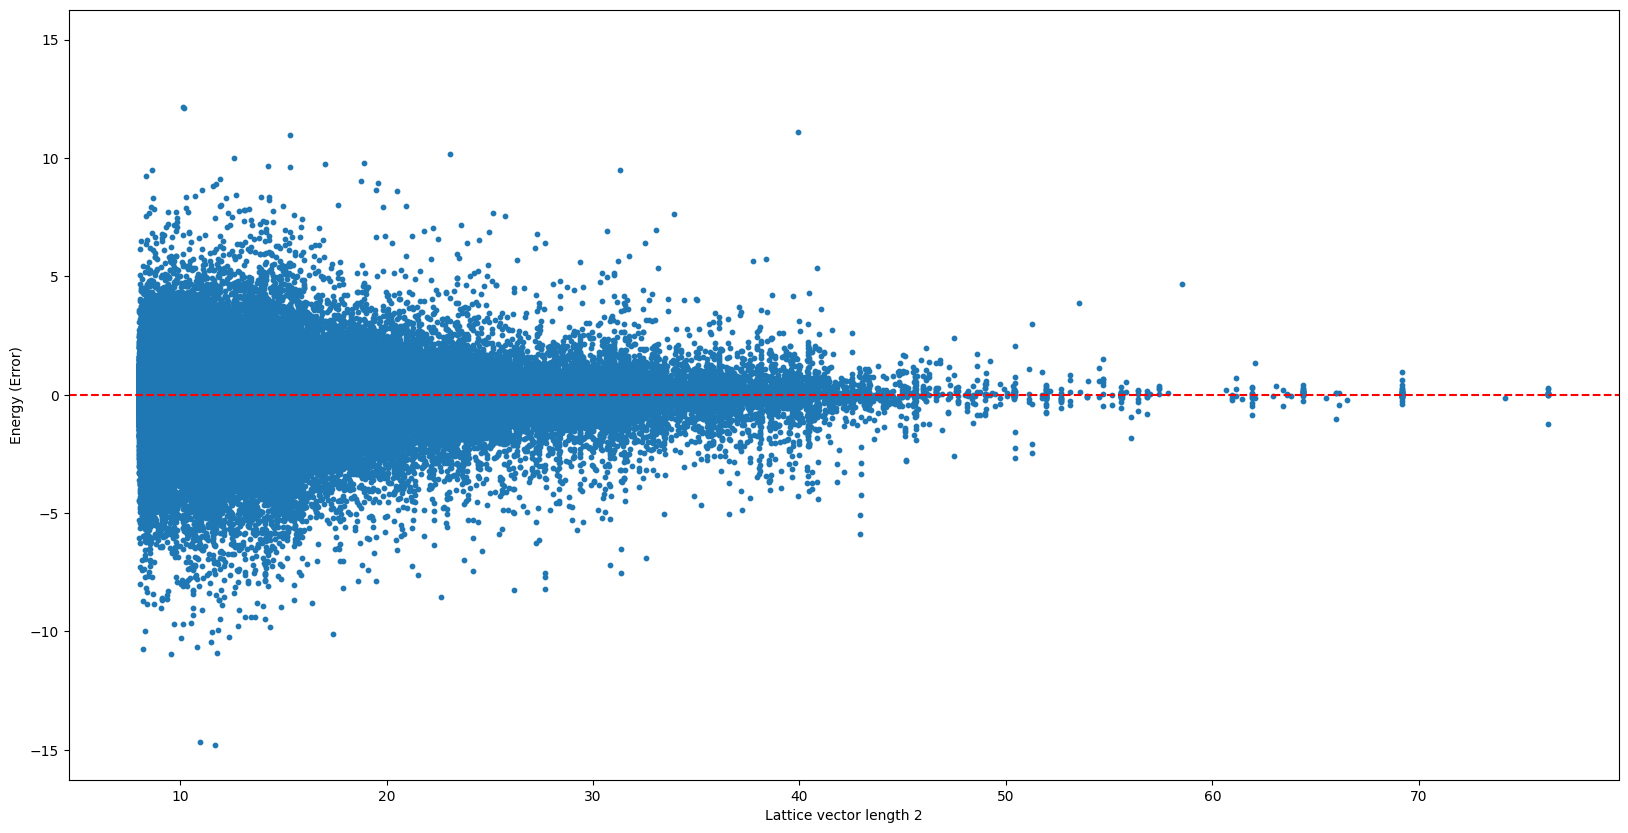

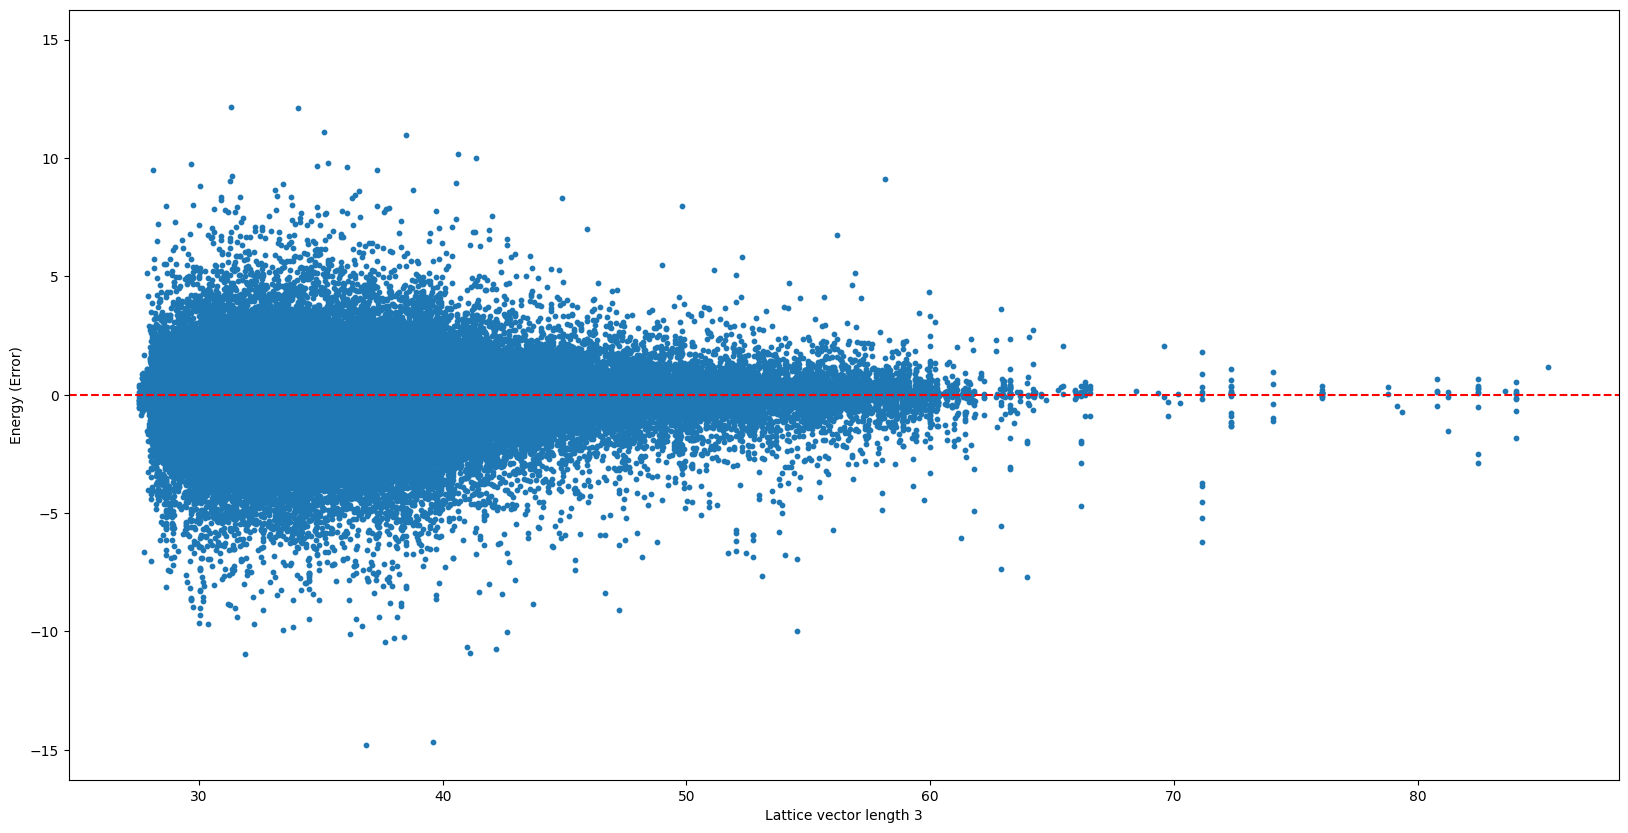

In [16]:
sort_plot_df(df, "Lattice vector length 1")
sort_plot_df(df, "Lattice vector length 2")
sort_plot_df(df, "Lattice vector length 3")


can try to split the unit cell into x,y,z coords
colour by spdf?
sort by element closest to adsorbate

# Distribution of Error (abs) when Sorted by Elements Present (Weighted and Unweighted)

In [17]:
elements = ['H',
                                                                                             'B', 'C', 'N', 'O',
            'Na',                                                                           'Al', 'Si', 'P', 'S', 'Cl',
            'K', 'Ca',      'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',      'Ga', 'Ge', 'As', 'Se',
            'Rb', 'Sr',     'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',      'In', 'Sn', 'Sb', 'Te', 
            'Cs',           'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',            'Tl', 'Pb', 'Bi']

#extract list of elements
#elements = []
#for i in range(len(df)):
#    elements += dataset_list[i].get_chemical_symbols()
#    elements = [*set(elements)]

unweighted_mean_errors = []
weighted_errors = []
weighted_mean_errors = []
print("   Unweighted Error     Weighted Error        no. of unit cells it is present in")
for count, element in enumerate(elements):    
    df_filtered = df[df['chemical formula'].str.contains(element)].reset_index(drop=True)

    unweighted_mean_error = df_filtered["energy (error)"].abs().mean() # absolute value is used
    unweighted_mean_errors.append(unweighted_mean_error)

    for i in range(len(df_filtered)):
        number_of_element_atom = df_filtered["chemical formula"][i].split(element)[1][:2]
        number_of_element_atom = ''.join(char for char in number_of_element_atom if char.isdigit())
        if number_of_element_atom == "":
            number_of_element_atom = 1
        else:
            number_of_element_atom = int(number_of_element_atom)
        weight = number_of_element_atom/df_filtered["number of atoms"][i]
        weighted_errors.append(df_filtered["energy (error)"].abs()[i] * weight)
    weighted_mean_errors.append(np.mean(weighted_errors))
    print(f'{element}: {unweighted_mean_error}   {weighted_mean_errors[count]}    {len(df_filtered)}')


plt.figure(figsize=(20,10))
plt.xlabel('Element')
plt.ylabel("Weighted Energy (Error)")

plt.bar(elements, weighted_mean_errors)

plt.show()


plt.figure(figsize=(10,5))
plt.xlabel('Element')
plt.ylabel("Unweighted Energy (Error)")

plt.bar(elements, unweighted_mean_errors)

plt.show()

   Unweighted Error     Weighted Error        no. of unit cells it is present in
